In [90]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score


In [91]:
data_set_conaminantes = pd.read_csv('../../data/processed/normalizados/Dataset_MinMax.csv',sep=';', thousands=None, decimal=',')
data_set_conaminantes['fecha'] = pd.to_datetime(data_set_conaminantes['fecha'])

In [92]:
# Crear columnas para cada estación y llenar con 0
data_set_conaminantes['es_Primavera'] = 0
data_set_conaminantes['es_Verano'] = 0
data_set_conaminantes['es_Otoño'] = 0
data_set_conaminantes['es_Invierno'] = 0

def get_estacion(fecha):
    dia = fecha.timetuple().tm_yday
    
    # Definiendo los días del año para los cambios de estación en el hemisferio sur
    verano = 355  # ~21 de diciembre
    otoño = 80     # ~21 de marzo
    invierno = 172  # ~21 de junio
    primavera = 264  # ~21 de septiembre
    
    # Determinar la estación basada en el día del año
    if verano <= dia or dia < otoño:
        return 'Verano'
    elif otoño <= dia < invierno:
        return 'Otoño'
    elif invierno <= dia < primavera:
        return 'Invierno'
    else:
        return 'Primavera'



# Actualizar las columnas de estación basado en la fecha
for index, row in data_set_conaminantes.iterrows():
    estacion = get_estacion(row['fecha'])
    
    if estacion == 'Primavera':
        data_set_conaminantes.at[index, 'es_Primavera'] = 1
    elif estacion == 'Verano':
        data_set_conaminantes.at[index, 'es_Verano'] = 1
    elif estacion == 'Otoño':
        data_set_conaminantes.at[index, 'es_Otoño'] = 1
    elif estacion == 'Invierno':
        data_set_conaminantes.at[index, 'es_Invierno'] = 1

In [93]:
data_set_conaminantes = data_set_conaminantes.drop(['fecha'],axis=1)
data_set_conaminantes = data_set_conaminantes.drop(['dd_Valor'],axis=1)


X = data_set_conaminantes[['humedad', 
                           'puntoRocio', 
                           'temperatura', 
                           'ff_Valor', 
                           'es_Primavera', 
                           'es_Verano', 
                           'es_Otoño', 
                           'es_Invierno']]

y = data_set_conaminantes[['pm10', 'pm2.5']]


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# El 20% restante se utilizará para pruebas y test finales.
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [94]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)  # Elegir el número de componentes principales deseados
X_pca = pca.fit_transform(X)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_temp_scaled = scaler.transform(X_temp)  # Nota: Usar la misma transformación del entrenamiento en los datos de prueba

# Aplicar PCA con 2 componentes principales
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_temp_pca = pca.transform(X_temp_scaled)  # Nota: Usar los componentes obtenidos en el entrenamiento

# Ver la varianza explicada por los componentes
print(f'Varianza explicada por los componentes: {pca.explained_variance_ratio_}')


Varianza explicada por los componentes: [0.3922348  0.17879473]


In [95]:
# Crear modelo de red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(1)  # Salida única, para predecir 'pm10' por ejemplo
])

# Compilar modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar modelo (usando pm10 como variable objetivo para este ejemplo)
model.fit(X_train_pca, y_train[['pm2.5']], epochs=50, validation_split=0.2, batch_size=42)


Epoch 1/50
57/57 [==============================] - 1s 6ms/step - loss: 0.0058 - val_loss: 7.4900e-04
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.4016e-04
Epoch 3/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.9039e-04
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.1126e-04
Epoch 5/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 8.0301e-04
Epoch 6/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.0120e-04
Epoch 7/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 6.6216e-04
Epoch 8/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 6.4263e-04
Epoch 9/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 7.1160e-04
Epoch 10/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0012 - 

In [96]:
# Predecir valores usando el modelo entrenado
y_pred_train = model.predict(X_train_pca)
y_pred_temp = model.predict(X_temp_pca)

# Calcular y mostrar métricas para el conjunto de entrenamiento
mse_train = mean_squared_error(y_train[['pm2.5']], y_pred_train)
rmse_train = mean_squared_error(y_train[['pm2.5']], y_pred_train, squared=False)  # si squared=False, retorna RMSE
r2_train = r2_score(y_train[['pm2.5']], y_pred_train)

print(f"Conjunto de Entrenamiento: MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}")

# Calcular y mostrar métricas para el conjunto temporal de prueba
mse_temp = mean_squared_error(y_temp[['pm2.5']], y_pred_temp)
rmse_temp = mean_squared_error(y_temp[['pm2.5']], y_pred_temp, squared=False)  # si squared=False, retorna RMSE
r2_temp = r2_score(y_temp[['pm10']], y_pred_temp)

print(f"Conjunto Temporal de Prueba: MSE: {mse_temp:.2f}, RMSE: {rmse_temp:.2f}, R2: {r2_temp:.2f}")

24/24 [==============================] - 0s 1ms/step
Conjunto de Entrenamiento: MSE: 0.00, RMSE: 0.03, R2: 0.46
Conjunto Temporal de Prueba: MSE: 0.00, RMSE: 0.05, R2: 0.10


C:\Users\gonch\AppData\Local\Temp\ipykernel_14192\2789119708.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_temp[['pm2.5']].min(), y_temp[['pm2.5']].max()],


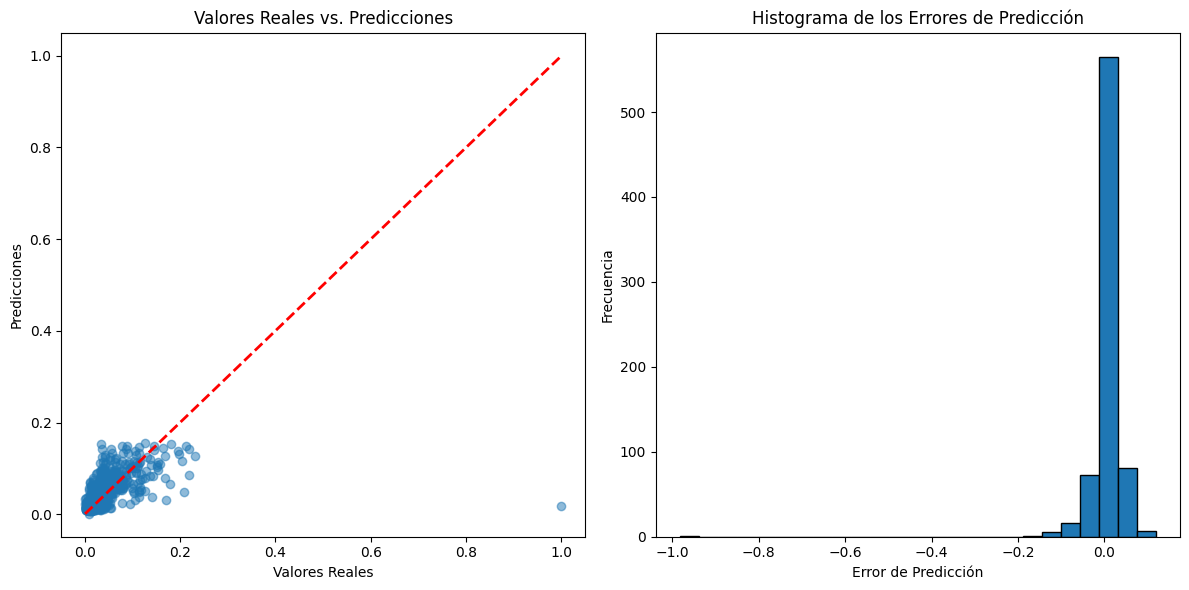

In [97]:
plt.figure(figsize=(12, 6))

# Gráfico de dispersión de valores reales vs. predichos
plt.subplot(1, 2, 1)
plt.scatter(y_temp[['pm2.5']], y_pred_temp, alpha=0.5)
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Línea de identidad: una línea diagonal donde y=x. 
# Los puntos en esta línea indican predicciones perfectas.
plt.plot([y_temp[['pm2.5']].min(), y_temp[['pm2.5']].max()], 
         [y_temp[['pm2.5']].min(), y_temp[['pm2.5']].max()],
         '--k', linewidth=2, color='red')

# Histograma de los errores de predicción
plt.subplot(1, 2, 2)
error = y_pred_temp.flatten() - y_temp[['pm2.5']].values.flatten()
plt.hist(error, bins=25, edgecolor='black')
plt.title('Histograma de los Errores de Predicción')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')

plt.tight_layout()  # Ajusta automáticamente los subgráficos para que encajen en la figura
plt.show()

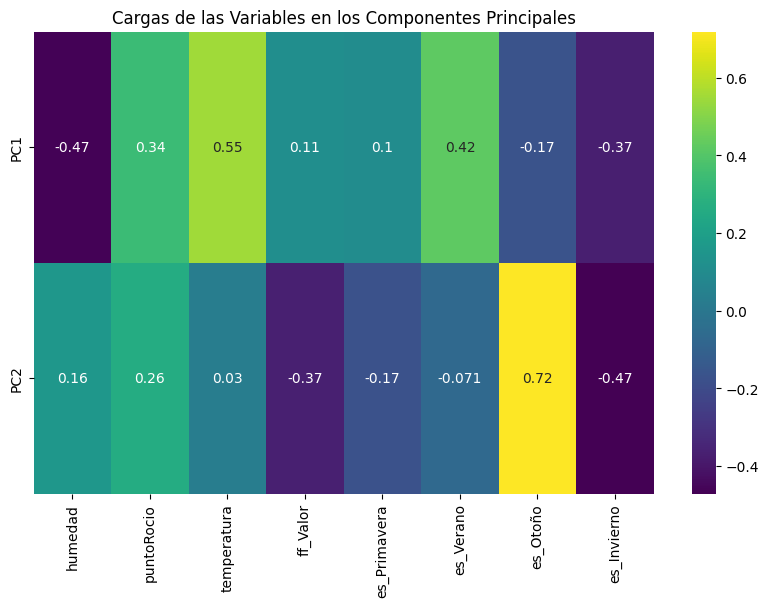

In [98]:
# Crear un DataFrame con los componentes
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i}' for i in range(1, 3)])

# Visualizar las cargas de las variables originales en los componentes principales
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, cmap='viridis', annot=True)
plt.title('Cargas de las Variables en los Componentes Principales')
plt.show()